In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# defining global variable path
# Location of my dataset on My Google Drive
path = "drive/My Drive/dataset"
import tensorflow as tf

def loadImages(path):
  image_files = list(paths.list_images(path))
  return image_files

In [5]:
imagePaths=loadImages(path)

In [8]:
# In[ ]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

data = []
labels = []

In [9]:

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# In[ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [17]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 39s 409ms/step - loss: 0.3372 - accuracy: 0.8476 - val_loss: 0.0980 - val_accuracy: 0.9740
Epoch 2/20
95/95 [==============================] - 38s 397ms/step - loss: 0.1141 - accuracy: 0.9608 - val_loss: 0.0679 - val_accuracy: 0.9792
Epoch 3/20
95/95 [==============================] - 38s 396ms/step - loss: 0.0777 - accuracy: 0.9727 - val_loss: 0.0518 - val_accuracy: 0.9818
Epoch 4/20
95/95 [==============================] - 37s 392ms/step - loss: 0.0661 - accuracy: 0.9799 - val_loss: 0.0587 - val_accuracy: 0.9805
Epoch 5/20
95/95 [==============================] - 37s 389ms/step - loss: 0.0599 - accuracy: 0.9776 - val_loss: 0.0519 - val_accuracy: 0.9818
Epoch 6/20
95/95 [==============================] - 38s 400ms/step - loss: 0.0481 - accuracy: 0.9842 - val_loss: 0.0334 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 38s 401ms/step - loss: 0.0459 - accuracy: 0.9852 - val_loss: 0.042

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [19]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [21]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       384
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       768
   macro avg       0.99      0.99      0.99       768
weighted avg       0.99      0.99      0.99       768



In [22]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('my_model.h5')

[INFO] saving mask detector model...


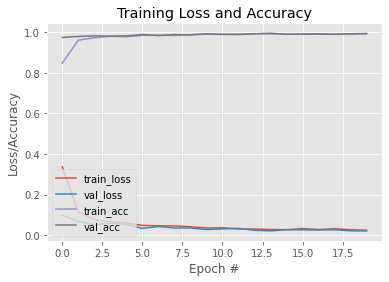

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')